In [2]:
import pandas as pd
원본 = pd.read_csv('기자간담회.csv')[['Date','Content']]
sola = pd.read_csv('C:/Users/campus4D035/Desktop/final/chat02/yotube/sola_기자간담회_요약.csv')[['Date', 'sola_summary','default_summary']]
gpt = pd.read_csv('C:/Users/campus4D035/Desktop/final/chat02/yotube/기자간담회_요약.csv')[['Date', 'costar_summary','default_summary']]

In [7]:
merged_df = 원본.merge(sola, on='Date').merge(gpt, on='Date')
merged_df.columns=['date',	'content',	'sola_costar_summary',	'sola_default_summary', 'gpt_costar_summary', 'gpt_default_summary']

# 비교를 위해 텍스트 정제

In [11]:
import pandas as pd
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    # 마크다운 기호 제거
    text = re.sub(r'#|[*_`]', '', text)
    # 줄바꿈 문자 제거
    text = text.replace('\\n', ' ').replace('\n', ' ')
    # 여러 공백 하나로
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
# 정제 적용
merged_df['content'] = merged_df['content'].apply(clean_text)
merged_df['sola_costar_summary'] = merged_df['sola_costar_summary'].apply(clean_text)
merged_df['sola_default_summary'] = merged_df['sola_default_summary'].apply(clean_text)
merged_df['gpt_costar_summary'] = merged_df['gpt_costar_summary'].apply(clean_text)
merged_df['gpt_default_summary'] = merged_df['gpt_default_summary'].apply(clean_text)

# ROUGE 평가

In [15]:
from rouge_score import rouge_scorer

# ROUGE 평가기 준비
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# 평가할 요약본 목록
summary_columns = [
    'sola_costar_summary',
    'sola_default_summary',
    'gpt_costar_summary',
    'gpt_default_summary'
]

# 결과 저장
rouge_results = []

for col in summary_columns:
    scores = [scorer.score(ref, hyp) 
              for ref, hyp in zip(merged_df['content'], merged_df[col])]
    
    # 평균 F1 계산
    avg_scores = {
        'model': col,
        'rouge1_f1': sum(s['rouge1'].fmeasure for s in scores) / len(scores),
        'rouge2_f1': sum(s['rouge2'].fmeasure for s in scores) / len(scores),
        'rougeL_f1': sum(s['rougeL'].fmeasure for s in scores) / len(scores),
    }
    rouge_results.append(avg_scores)

# 결과 출력
rouge_df = pd.DataFrame(rouge_results)
print(rouge_df)

                  model  rouge1_f1  rouge2_f1  rougeL_f1
0   sola_costar_summary   0.330585   0.234487   0.261477
1  sola_default_summary   0.294305   0.200874   0.241030
2    gpt_costar_summary   0.134742   0.099274   0.127962
3   gpt_default_summary   0.059693   0.050993   0.059693


In [22]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

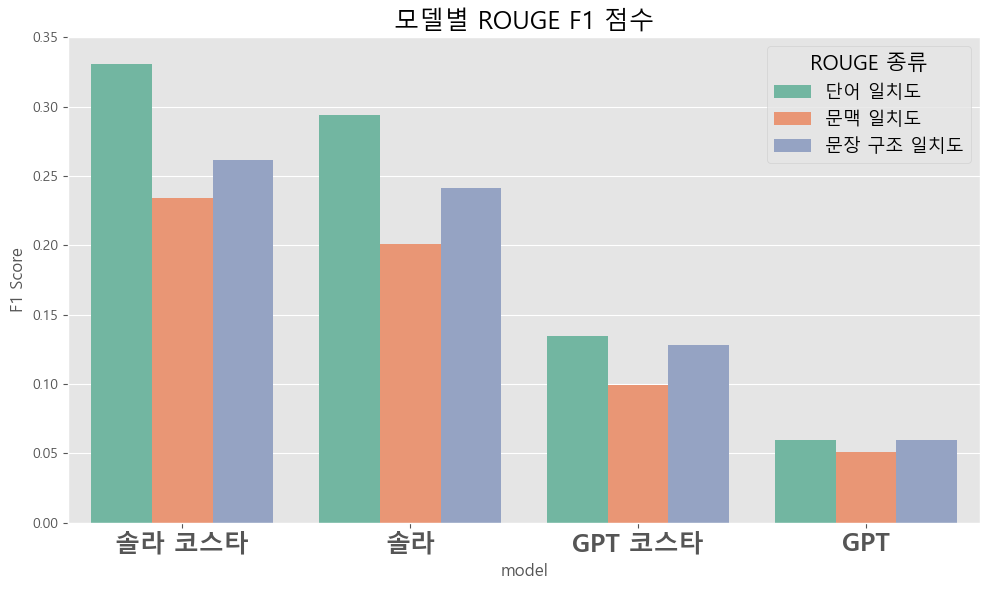

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# ROUGE 그래프
plt.figure(figsize=(10, 6))

# 데이터 변형 (long format)
rouge_melted = rouge_df.melt(
    id_vars='model',
    value_vars=['rouge1_f1' # rouge1_f1 단일 단어 : 단어 수준 일치도 평가
                , 'rouge2_f1' # rouge2_f1 연속 단어 2개 : 문맥 수준 일치도 평가
                , 'rougeL_f1'], # rougeL_f1 최장 공통 부분열 : 문장 구조 일치도 평가
    var_name='ROUGE Type',
    value_name='F1 Score'
)

label_map = {
    'rouge1_f1': '단어 일치도',
    'rouge2_f1': '문맥 일치도',
    'rougeL_f1': '문장 구조 일치도'
}
rouge_melted['ROUGE Type'] = rouge_melted['ROUGE Type'].map(label_map)
custom_labels = ['솔라 코스타', '솔라', 'GPT 코스타', 'GPT']

ax = sns.barplot(data=rouge_melted, x='model', y='F1 Score', hue='ROUGE Type', palette='Set2')
plt.title('모델별 ROUGE F1 점수', fontsize=18)
plt.ylim(0, 0.35)
xtick_locs = ax.get_xticks()
plt.xticks(ticks=xtick_locs, labels=custom_labels, fontsize=18, fontweight='bold')
plt.legend(title='ROUGE 종류', fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.show()


# BERTScore 평가

In [18]:
from bert_score import score

# 평가할 요약본 목록
summary_columns = [
    'sola_costar_summary',
    'sola_default_summary',
    'gpt_costar_summary',
    'gpt_default_summary'
]

bert_results = []

for col in summary_columns:
    P, R, F1 = score(merged_df[col].tolist(), merged_df['content'].tolist(), lang="ko")
    avg_f1 = F1.mean().item()
    bert_results.append({
        'model': col,
        'bertscore_f1': avg_f1
    })

# 결과 출력
bert_df = pd.DataFrame(bert_results)
print(bert_df)


c:\Users\campus4D035\Desktop\final\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\campus4D035\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back t

                  model  bertscore_f1
0   sola_costar_summary      0.735692
1  sola_default_summary      0.715353
2    gpt_costar_summary      0.779938
3   gpt_default_summary      0.727243


C:\Users\campus4D035\AppData\Local\Temp\ipykernel_17412\3593544114.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=bert_df, x='model', y='bertscore_f1', palette=custom_colors)


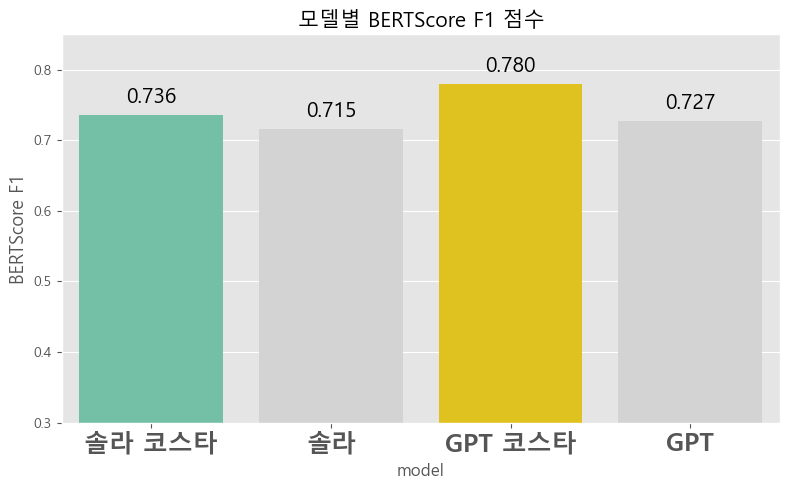

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수정된 색상
custom_colors = ['#66CDAA', '#D3D3D3', '#FFD700', '#D3D3D3']
custom_labels = ['솔라 코스타', '솔라', 'GPT 코스타', 'GPT']

# 그래프
plt.figure(figsize=(8, 5))
bars = sns.barplot(data=bert_df, x='model', y='bertscore_f1', palette=custom_colors)

plt.title('모델별 BERTScore F1 점수', fontsize=15)
plt.ylim(0.3, 0.85)
plt.xticks(ticks=xtick_locs, labels=custom_labels, fontsize=18, fontweight='bold')
plt.ylabel('BERTScore F1', fontsize=13)

# 수치 표시
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=15
    )

plt.tight_layout()
plt.show()